# KRAMERS TIME-DEPENDENT RATES (KTR) METHOD

## Introduction

In this tutorial we illustrate the use of the KTR method to estimate the intrinsic rate (k_o) and the quality of bias (gamma) from metadynamics simulations by fitting numerically the cumulative distribution function.

We provide the scripts for the analysis of the COLVAR files from PLUMED.

Reference paper: Palacio-Rodriguez, Vroylandt, Stelzl, Pietrucci, Hummer, & Cossio. (2021) [arXiv:2109.11360](https://arxiv.org/abs/2109.11360).

In [133]:
# Import dependencies
import os, sys
sys.path.append(os.path.abspath('../LM_KTR'))
import numpy as np
import glob
import LM_KTR.LM_KTR as KTR
from matplotlib import pyplot as plt
from scipy import interpolate, optimize
import multiprocessing as mp
from functools import partial
%matplotlib inline

We use as example the data for the C_240 fullerene dimer in water solution, using a deposition time of 5 ps (see Fig. 3 on the reference paper). A total af 50 metadynamics simulations were performed (see reference paper for details). All the COLVAR files are provided in the colvars directory.

To estimate k_o and gamma we follow this procedure:
1) We extract the average maximum bias (VMB) and the jump-times.
2) We fit the VMB using splines and optimize the likelihood function.
3) We extract gamma and k_o.
4) We compare the theoretical and empirical distribution function.

Initially, we load the date from the colvar files.

In [134]:
# Load all colvar files
numprocs = 8
colvars = glob.glob("colvars/*")
colvars_count = len(colvars)
colvars_maxrow_count = None

data = []
final_times = np.zeros((colvars_count, 2))
for colvar in colvars:
    data.append(np.loadtxt(colvar))
    colvars_maxrow_count = data[-1].shape[0] if colvars_maxrow_count is None or colvars_maxrow_count < data[-1].shape[0] else colvars_maxrow_count
    i = len(data) - 1
    final_times[i,:] = np.array([data[-1][-1][0],data[-1][-1][0] * data[-1][-1][2]])
    i = i+1

# Print first lines to check that the data is loaded correctly
print(f'Number of colvar files    : {colvars_count}')
print(f'Max number of overall rows: {colvars_maxrow_count}')
print('Example of loaded data:')
print('#! FIELDS time d metad.bias acceleration.factor') # Corresponding columns for our example
print(data[0][:10])

Number of colvar files    : 50
Max number of overall rows: 33829
Example of loaded data:
#! FIELDS time d metad.bias acceleration.factor
[[0.       1.676266 0.       1.      ]
 [0.1      1.672725 0.       1.      ]
 [0.2      1.673073 0.       1.      ]
 [0.3      1.676354 0.       1.      ]
 [0.4      1.677375 0.       1.      ]
 [0.5      1.674929 0.       1.      ]
 [0.6      1.671249 0.       1.      ]
 [0.7      1.66508  0.       1.      ]
 [0.8      1.660368 0.       1.      ]
 [0.9      1.658337 0.       1.      ]]


Then, we estimate and plot the average maximum bias VMB

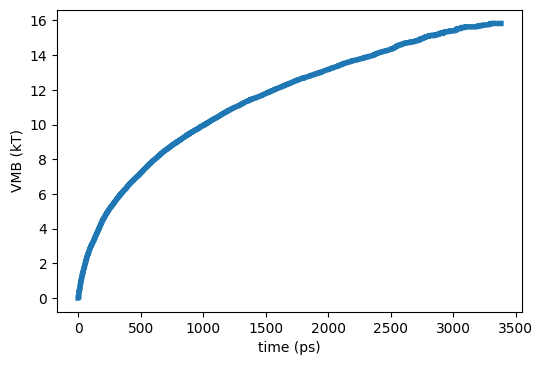

In [135]:
# Estimate maximum bias for each colvar file
def set_max_accumulate(dataset, numcol = 2):
    max_value_found = None
    for i in range(dataset.shape[0]):
        max_value_found = dataset[i][numcol] if max_value_found is None or max_value_found < dataset[i][numcol] else max_value_found
        dataset[i][numcol] = max_value_found

for i in range(colvars_count):
    set_max_accumulate(data[i])

# Estimate average maximum bias (VMB) over all the colvars
vmb_data = np.empty((colvars_count, colvars_maxrow_count))
vmb_data.fill(np.nan)
ix_col = None

def fill_vmb_data(colvar_index):
    vmb_column_data = data[colvar_index][:,2]
    diff_rows = colvars_maxrow_count - vmb_column_data.shape[0]
    if 0 < diff_rows:
        fill_diff = np.empty(diff_rows)
        fill_diff.fill(np.nan)
        vmb_column_data = np.hstack((vmb_column_data, fill_diff))
    vmb_data[colvar_index,:] = vmb_column_data
    return data[colvar_index][:,0] if data[colvar_index][:,0].shape[0] == colvars_maxrow_count else None

for i in range(colvars_count):
    i_ix_col = fill_vmb_data(i)
    if None is not i_ix_col:
        ix_col = i_ix_col

masked_vmb = np.ma.masked_array(vmb_data, np.isnan(vmb_data))
vmb_average = np.ma.average(masked_vmb.T, axis=1)
vmb_average = np.vstack((ix_col, vmb_average)).T

# Plot VMB
fig,ax = plt.subplots(figsize=(6,4),dpi=100)
ax.set_xlabel('time (ps)')
ax.set_ylabel('VMB (kT)')

plt.plot(vmb_average[:,0], vmb_average[:,1], lw=4)
np.savetxt('VMB.txt', vmb_average)
np.savetxt('FINALTIMES.txt', final_times)
fig.show()

Next, we extract k_o and gamma. To do so, we import some functions from the [main code](../LM_KTR/LM_KTR.py)

In [136]:
# Input data
t_total = 1e6
t = final_times[:,0]
VMB='tutorial'
unique_T = vmb_average[:,0]
unique_V = vmb_average[:,1]
spline = interpolate.UnivariateSpline(unique_T, unique_V, s=0, ext=3)
event = t < t_total
opt = optimize.minimize_scalar(KTR.calculate_log_l, bounds=(0.0, 1.0), method='bounded', args=(event, t, spline))
gamma = opt.x

p =  mp.Pool(4)
func = partial(KTR.calculate_cum_hazard, gamma, spline)
cum_hazard = np.array(p.map(func, t))
p.close()

mean_t = cum_hazard.sum() / event.sum()
result = np.array([1/mean_t, gamma])
# Output1: gamma and k_o
print("gamma", result[1],"k_o", result[0])


gamma 0.8062882475782995 k_o 2.620754667570759e-08


As a consistency check, we plot VMB and the splines fit

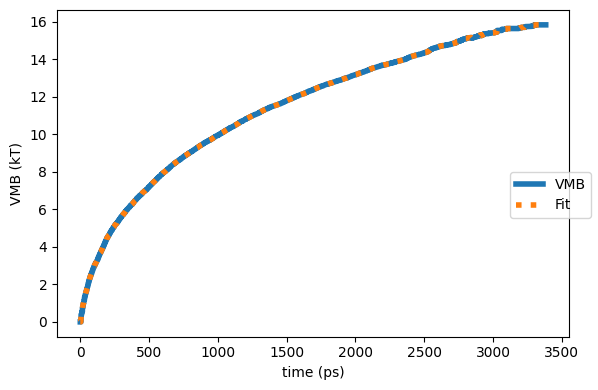

In [145]:
# Output2: VMB plot

# Save splines VMB fit
t_range=np.linspace(0,np.max(t),1000)
V_range=spline(t_range)
spline_data = np.column_stack((t_range,V_range))
np.savetxt('spline_{}.txt'.format(VMB),spline_data)

fig, ax = plt.subplots(figsize=(6,4),dpi=100)
ax.set_xlabel('time (ps)')
ax.set_ylabel('VMB (kT)')
ax.plot(vmb_average[:,0], vmb_average[:,1], label='VMB', lw=4)
plt.plot(spline_data[:, 0], spline_data[:, 1], label='Fit', ls=':', lw=4)
ax.plot()
fig.legend(loc='center right')
fig.tight_layout()
fig.show()

Finally, we plot the empirical CDF and the theoretical CDF

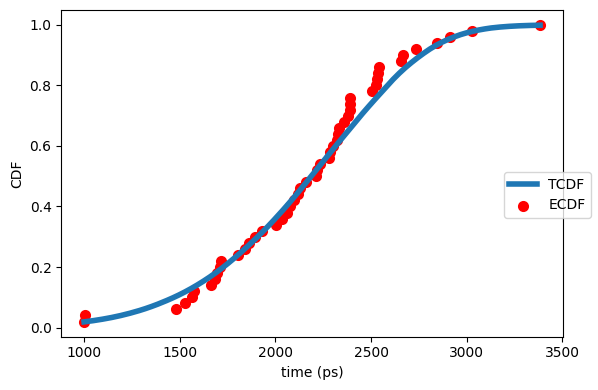

In [144]:
# Output3: CDF fit

# Save cumulative distribution functions (CDFs)

# Save empirical CDF
counts = np.sort(t)
norm = t.size
ecdf = np.arange(1, norm + 1) / norm
ecdf_data=np.column_stack((counts, ecdf))
np.savetxt('ecdf_{}.txt'.format(VMB), ecdf_data)

# Save theoretical CDF fitted from likelihood
t_range = np.linspace(np.min(t), np.max(t), 150)
cdfvals = KTR.cumulative_density_fct(gamma, mean_t, spline, t_range)
tcdf_data=np.column_stack((t_range, cdfvals))
np.savetxt('tcdf_{}.txt'.format(VMB), tcdf_data)

# Save likelihood - objetive function
np.savetxt('obj_likelihood_{}.txt'.format(VMB),np.column_stack(KTR.ll_objective_function(spline,t,event)))

fig, ax = plt.subplots(figsize=(6,4),dpi=100)
ax.set_xlabel('time (ps)')
ax.set_ylabel('CDF')
ax.plot(tcdf_data[:, 0], tcdf_data[:, 1], label='TCDF', lw=4)
plt.scatter(ecdf_data[:,0], ecdf_data[:,1], lw=2, label='ECDF', marker='o', c='red')
ax.plot()
fig.legend(loc='center right')
fig.tight_layout()
fig.show()